**Copyright 2018 The TF-Agents Authors.**

### Get Started
<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/agents/blob/master/tf_agents/colabs/7_SAC_minitaur_tutorial.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/agents/blob/master/tf_agents/colabs/7_SAC_minitaur_tutorial.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>


In [6]:
# Note: If you haven't installed the following dependencies, run:
#!apt-get install xvfb
#!pip install 'gym==0.10.11'
#!pip install 'imageio==2.4.0'
#!pip install matplotlib
pip install PILLOW
#!pip install tf-agents-nightly
#!pip install 'pybullet==2.4.2'
try:
  %%tensorflow_version 2.x
except:
  pass


SyntaxError: invalid syntax (<ipython-input-6-f66a2b629bc6>, line 6)

## Introduction

This example shows how to train a [Soft Actor Critic](https://arxiv.org/abs/1801.01290)  agent on the [Minitaur](https://github.com/bulletphysics/bullet3/blob/master/examples/pybullet/gym/pybullet_envs/bullet/minitaur.py) environment using the TF-Agents library.

If you've worked through the [DQN Colab](https://github.com/tensorflow/agents/blob/master/tf_agents/colabs/1_dqn_tutorial.ipynb) this should feel very familiar. Notable changes include:

  * Changing the agent from DQN to SAC.
  * Training on Minitaur which is a much more complex environment than CartPole. The Minitaur environment aims to train a quadruped robot to move forward.
  * We do not use a random policy to perform an initial data collection.


## Setup

First we will import the different tools that we need and make sure we enable TF-V2 behavior as it is easier to iterate in Eager mode throughout the colab.

In [5]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import base64
import imageio
import IPython
import matplotlib
import matplotlib.pyplot as plt
import PIL.Image

import tensorflow as tf
tf.compat.v1.enable_v2_behavior()

from tf_agents.agents.ddpg import critic_network
from tf_agents.agents.sac import sac_agent
from tf_agents.drivers import dynamic_step_driver
from tf_agents.environments import suite_pybullet
from tf_agents.environments import tf_py_environment
from tf_agents.eval import metric_utils
from tf_agents.metrics import tf_metrics
from tf_agents.networks import actor_distribution_network
from tf_agents.networks import normal_projection_network
from tf_agents.policies import greedy_policy
from tf_agents.policies import random_tf_policy
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.trajectories import trajectory
from tf_agents.utils import common


## Hyperparameters

In [2]:
env_name = "MinitaurBulletEnv-v0" # @param {type:"string"}
num_iterations = 1000000 # @param {type:"integer"}

initial_collect_steps = 10000 # @param {type:"integer"} 
collect_steps_per_iteration = 1 # @param {type:"integer"}
replay_buffer_capacity = 1000000 # @param {type:"integer"}

batch_size = 256 # @param {type:"integer"}

critic_learning_rate = 3e-4 # @param {type:"number"}
actor_learning_rate = 3e-4 # @param {type:"number"}
alpha_learning_rate = 3e-4 # @param {type:"number"}
target_update_tau = 0.005 # @param {type:"number"}
target_update_period = 1 # @param {type:"number"}
gamma = 0.99 # @param {type:"number"}
reward_scale_factor = 1.0 # @param {type:"number"}
gradient_clipping = None # @param

actor_fc_layer_params = (256, 256)
critic_joint_fc_layer_params = (256, 256)

log_interval = 5000 # @param {type:"integer"}

num_eval_episodes = 30 # @param {type:"integer"}
eval_interval = 10000 # @param {type:"integer"}

## Environment

Environments in RL represent the task or problem that we are trying to solve. Standard environments can be easily created in TF-Agents using `suites`. We have different `suites` for loading environments from sources such as the OpenAI Gym, Atari, DM Control, etc., given a string environment name.

Now let's load the Minituar environment from the Pybullet suite.

urdf_root=/usr/lib/python3.7/site-packages/pybullet_data
options= 


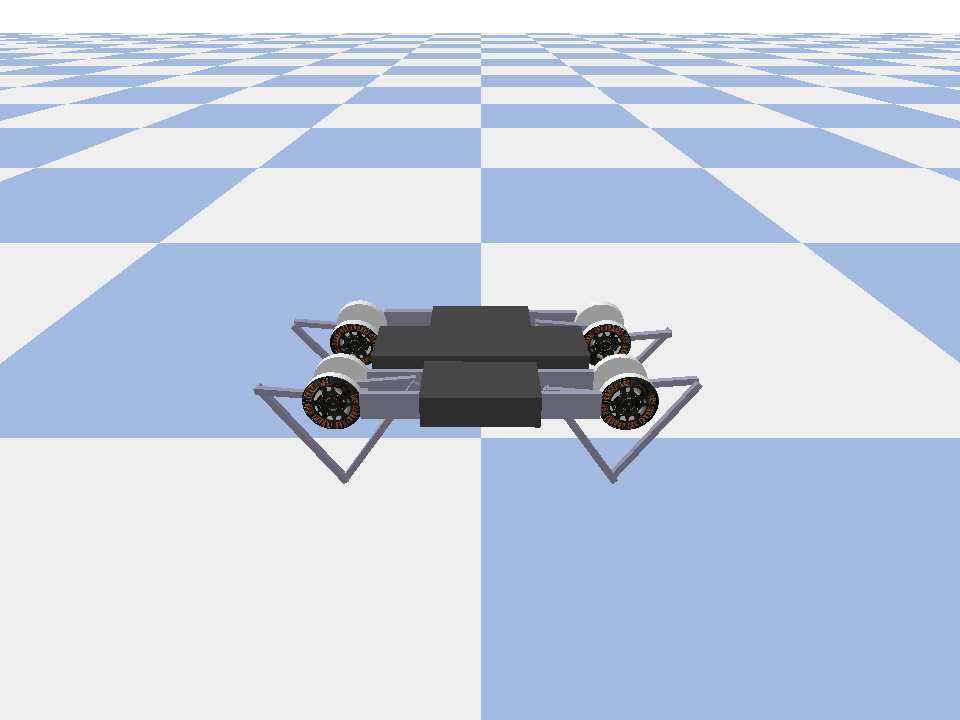

In [6]:
env = suite_pybullet.load(env_name)
env.reset()
PIL.Image.fromarray(env.render())

In this environment the goal is for the agent to train a policy that will control the Minitaur robot and have it move forward as fast as possible. Episodes last 1000 steps and the return will be the sum of rewards throughout the episode. 

Let's look at the information the environment provides as an `observation` which the policy will use to generate `actions`.

In [7]:
print('Observation Spec:')
print(env.time_step_spec().observation)
print('Action Spec:')
print(env.action_spec())

Observation Spec:
BoundedArraySpec(shape=(28,), dtype=dtype('float32'), name='observation', minimum=[  -3.1515927   -3.1515927   -3.1515927   -3.1515927   -3.1515927
   -3.1515927   -3.1515927   -3.1515927 -167.72488   -167.72488
 -167.72488   -167.72488   -167.72488   -167.72488   -167.72488
 -167.72488     -5.71        -5.71        -5.71        -5.71
   -5.71        -5.71        -5.71        -5.71        -1.01
   -1.01        -1.01        -1.01     ], maximum=[  3.1515927   3.1515927   3.1515927   3.1515927   3.1515927   3.1515927
   3.1515927   3.1515927 167.72488   167.72488   167.72488   167.72488
 167.72488   167.72488   167.72488   167.72488     5.71        5.71
   5.71        5.71        5.71        5.71        5.71        5.71
   1.01        1.01        1.01        1.01     ])
Action Spec:
BoundedArraySpec(shape=(8,), dtype=dtype('float32'), name='action', minimum=-1.0, maximum=1.0)


As we can see the observation is fairly complex. We recieve 28 values representing the angles, velocities and torques for all the motors. In return the environment expects 8 values for the actions between `[-1, 1]`. These are the desired motor angles.


Usually we create two environments: one for training and one for evaluation. Most environments are written in pure python, but they can be easily converted to TensorFlow using the `TFPyEnvironment` wrapper. The original environment's API uses numpy arrays, the `TFPyEnvironment` converts these to/from `Tensors` for you to more easily interact with TensorFlow policies and agents.


In [8]:
train_py_env = suite_pybullet.load(env_name)
eval_py_env = suite_pybullet.load(env_name)

train_env = tf_py_environment.TFPyEnvironment(train_py_env)
eval_env = tf_py_environment.TFPyEnvironment(eval_py_env)

urdf_root=/usr/lib/python3.7/site-packages/pybullet_data
options= 
urdf_root=/usr/lib/python3.7/site-packages/pybullet_data
options= 


## Agent

To create an SAC Agent, we first need to create the networks that it will train. SAC is an actor-critic agent and so we will need two networks.

The critic will give us value estimates for `Q(s,a)`. That is, it will recieve as input an observation and an action, and it will give us an estimate of how good that action was for the given state.


In [9]:
observation_spec = train_env.observation_spec()
action_spec = train_env.action_spec()
critic_net = critic_network.CriticNetwork(
    (observation_spec, action_spec),
    observation_fc_layer_params=None,
    action_fc_layer_params=None,
    joint_fc_layer_params=critic_joint_fc_layer_params)

We will use this critic to train an `actor` network which will allow us to generate actions given an observation.

The `ActorNetwork` will predict parameters for a Normal distribution. This distribution will then be sampled, conditioned on the current observation,
, whenever we need to generate actions.

In [10]:
def normal_projection_net(action_spec,init_means_output_factor=0.1):
  return normal_projection_network.NormalProjectionNetwork(
      action_spec,
      mean_transform=None,
      state_dependent_std=True,
      init_means_output_factor=init_means_output_factor,
      std_transform=sac_agent.std_clip_transform,
      scale_distribution=True)


actor_net = actor_distribution_network.ActorDistributionNetwork(
    observation_spec,
    action_spec,
    fc_layer_params=actor_fc_layer_params,
    continuous_projection_net=normal_projection_net)

With these networks at hand we can now instantiate the agent.





In [11]:
global_step = tf.compat.v1.train.get_or_create_global_step()
tf_agent = sac_agent.SacAgent(
    train_env.time_step_spec(),
    action_spec,
    actor_network=actor_net,
    critic_network=critic_net,
    actor_optimizer=tf.compat.v1.train.AdamOptimizer(
        learning_rate=actor_learning_rate),
    critic_optimizer=tf.compat.v1.train.AdamOptimizer(
        learning_rate=critic_learning_rate),
    alpha_optimizer=tf.compat.v1.train.AdamOptimizer(
        learning_rate=alpha_learning_rate),
    target_update_tau=target_update_tau,
    target_update_period=target_update_period,
    td_errors_loss_fn=tf.compat.v1.losses.mean_squared_error,
    gamma=gamma,
    reward_scale_factor=reward_scale_factor,
    gradient_clipping=gradient_clipping,
    train_step_counter=global_step)
tf_agent.initialize()

Instructions for updating:
SeedStream has moved to `tfp.util.SeedStream`.
Instructions for updating:
`AffineScalar` bijector is deprecated; please use `tfb.Shift(loc)(tfb.Scale(...))` instead.


## Policies

In TF-Agents, policies represent the standard notion of policies in RL: given a `time_step` produce an action or a distribution over actions. The main method is `policy_step = policy.step(time_step)` where `policy_step` is a named tuple `PolicyStep(action, state, info)`.  The `policy_step.action` is the `action` to be applied to the environment, `state` represents the state for stateful (RNN) policies and `info` may contain auxiliary information such as log probabilities of the actions.

Agents contain two policies: the main policy (agent.policy) and the behavioral policy that is used for data collection (agent.collect_policy). For evaluation/deployment, we take the mean action by wrapping the main policy with GreedyPolicy().

In [12]:
eval_policy = greedy_policy.GreedyPolicy(tf_agent.policy)
collect_policy = tf_agent.collect_policy

## Metrics and Evaluation

The most common metric used to evaluate a policy is the average return. The return is the sum of rewards obtained while running a policy in an environment for an episode, and we usually average this over a few episodes. We can compute the average return metric as follows.


In [13]:
def compute_avg_return(environment, policy, num_episodes=5):

  total_return = 0.0
  for _ in range(num_episodes):

    time_step = environment.reset()
    episode_return = 0.0

    while not time_step.is_last():
      action_step = policy.action(time_step)
      time_step = environment.step(action_step.action)
      episode_return += time_step.reward
    total_return += episode_return

  avg_return = total_return / num_episodes
  return avg_return.numpy()[0]


compute_avg_return(eval_env, eval_policy, num_eval_episodes)

# Please also see the metrics module for standard implementations of different
# metrics.

-0.026087727

## Replay Buffer

In order to keep track of the data collected from the environment, we will use the TFUniformReplayBuffer. This replay buffer is constructed using specs describing the tensors that are to be stored, which can be obtained from the agent using `tf_agent.collect_data_spec`.

In [14]:
replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=tf_agent.collect_data_spec,
    batch_size=train_env.batch_size,
    max_length=replay_buffer_capacity)

For most agents, the `collect_data_spec` is a `Trajectory` named tuple containing the observation, action, reward etc.

## Data Collection

Now we will create a driver to collect experience to seed the replay buffer with. Drivers provide us with a simple way to collecter `n` steps or episodes on an environment using a specific policy.

In [15]:
initial_collect_driver = dynamic_step_driver.DynamicStepDriver(
        train_env,
        collect_policy,
        observers=[replay_buffer.add_batch],
        num_steps=initial_collect_steps)
initial_collect_driver.run()

(TimeStep(step_type=<tf.Tensor: id=3353265, shape=(1,), dtype=int32, numpy=array([1], dtype=int32)>, reward=<tf.Tensor: id=3353266, shape=(1,), dtype=float32, numpy=array([-0.00657631], dtype=float32)>, discount=<tf.Tensor: id=3353267, shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>, observation=<tf.Tensor: id=3353268, shape=(1, 28), dtype=float32, numpy=
 array([[ 2.08211327e+00,  1.71571732e+00,  1.93392038e+00,
          6.75250649e-01,  2.36800480e+00,  2.08290482e+00,
          1.59396029e+00,  2.71569848e+00,  3.47901344e+01,
          1.83392239e+01,  8.43932343e+00,  3.47757578e+00,
         -1.05753307e+01, -1.10122595e+01,  3.27169847e+00,
          2.03289490e+01,  3.00681806e+00,  4.97536302e-01,
          6.96158350e-01,  1.33906698e+00, -5.69999981e+00,
         -1.48078418e+00,  2.48341292e-01,  5.46637654e-01,
         -1.80297673e-01, -1.23173937e-01,  3.94605519e-03,
          9.75861371e-01]], dtype=float32)>), ())

In order to sample data from the replay buffer, we will create a `tf.data` pipeline which we can feed to the agent for training later. We can specify the `sample_batch_size` to configure the number of items sampled from the replay buffer. We can also optimize the data pipeline using parallel calls and prefetching.

In order to save space, we only store the current observation in each row of the replay buffer. But since the SAC Agent needs both the current and next observation to compute the loss, we always sample two adjacent rows for each item in the batch by setting `num_steps=2`.

In [18]:
# Dataset generates trajectories with shape [Bx2x...]
dataset = replay_buffer.as_dataset(
    num_parallel_calls=3, sample_batch_size=batch_size, num_steps=2).prefetch(3)

iterator = iter(dataset)

## Training the agent

The training loop involves both collecting data from the environment and optimizing the agent's networks. Along the way, we will occasionally evaluate the agent's policy to see how we are doing.

In [19]:
collect_driver = dynamic_step_driver.DynamicStepDriver(
    train_env,
    collect_policy,
    observers=[replay_buffer.add_batch],
    num_steps=collect_steps_per_iteration)

In [21]:
%%time
#@test {"skip": true}

# (Optional) Optimize by wrapping some of the code in a graph using TF function.
tf_agent.train = common.function(tf_agent.train)
collect_driver.run = common.function(collect_driver.run)

# Reset the train step
tf_agent.train_step_counter.assign(0)

# Evaluate the agent's policy once before training.
avg_return = compute_avg_return(eval_env, eval_policy, num_eval_episodes)
returns = [avg_return]

for _ in range(num_iterations):

  # Collect a few steps using collect_policy and save to the replay buffer.
  for _ in range(collect_steps_per_iteration):
    collect_driver.run()

  # Sample a batch of data from the buffer and update the agent's network.
  experience, unused_info = next(iterator)
  train_loss = tf_agent.train(experience)

  step = tf_agent.train_step_counter.numpy()

  if step % log_interval == 0:
    print('step = {0}: loss = {1}'.format(step, train_loss.loss))

  if step % eval_interval == 0:
    avg_return = compute_avg_return(eval_env, eval_policy, num_eval_episodes)
    print('step = {0}: Average Return = {1}'.format(step, avg_return))
    returns.append(avg_return)

step = 5000: loss = -69.5007553100586
step = 10000: loss = -77.39860534667969
step = 10000: Average Return = 0.004204467870295048
step = 15000: loss = -48.33993148803711
step = 20000: loss = -33.14604949951172
step = 20000: Average Return = -2.5056986808776855
step = 25000: loss = -22.693758010864258
step = 30000: loss = -14.72395133972168
step = 30000: Average Return = -1.3735178709030151
step = 35000: loss = 0.20621967315673828
step = 40000: loss = -11.059686660766602
step = 40000: Average Return = -3.298039674758911
step = 45000: loss = -1.7697749137878418
step = 50000: loss = -5.364185333251953
step = 50000: Average Return = -1.2840650081634521
step = 55000: loss = 0.45703864097595215
step = 60000: loss = 7.4759345054626465
step = 60000: Average Return = -2.7788970470428467
step = 65000: loss = 1.4466521739959717
step = 70000: loss = -5.61122989654541
step = 70000: Average Return = -1.3685824871063232
step = 75000: loss = -4.2794671058654785
step = 80000: loss = -2.1087839603424072

KeyboardInterrupt: 

## Visualization



### Plots

We can plot average return vs global steps to see the performance of our agent. In `Minitaur`, the reward function is based on how far the minitaur walks in 1000 steps and penalizes the energy expenditure.

ValueError: x and y must have same first dimension, but have shapes (101,) and (25,)

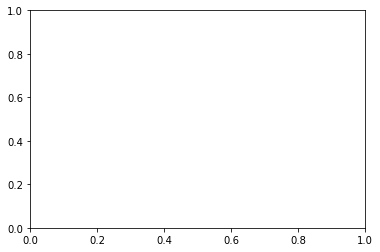

In [22]:
#@test {"skip": true}

steps = range(0, num_iterations + 1, eval_interval)
plt.plot(steps, returns)
plt.ylabel('Average Return')
plt.xlabel('Step')
plt.ylim()

### Videos

It is helpful to visualize the performance of an agent by rendering the environment at each step. Before we do that, let us first create a function to embed videos in this colab.

In [23]:
def embed_mp4(filename):
  """Embeds an mp4 file in the notebook."""
  video = open(filename,'rb').read()
  b64 = base64.b64encode(video)
  tag = '''
  <video width="640" height="480" controls>
    <source src="data:video/mp4;base64,{0}" type="video/mp4">
  Your browser does not support the video tag.
  </video>'''.format(b64.decode())

  return IPython.display.HTML(tag)

The following code visualizes the agent's policy for a few episodes:

In [ ]:
num_episodes = 3
video_filename = 'sac_minitaur.mp4'
with imageio.get_writer(video_filename, fps=60) as video:
  for _ in range(num_episodes):
    time_step = eval_env.reset()
    video.append_data(eval_py_env.render())
    while not time_step.is_last():
      action_step = tf_agent.policy.action(time_step)
      time_step = eval_env.step(action_step.action)
      video.append_data(eval_py_env.render())

embed_mp4(video_filename)